In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore', category=UserWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, probplot, t
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch
import pickle
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet, MultiNormalizer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss, MAE, SMAPE, MultiLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# For time stamps
from datetime import datetime, timedelta

plt.style.use('fivethirtyeight')
%matplotlib inline


### Predicting the closing price of Bitcoin:

### Checking Data

In [2]:
# Get the stock quote
columns = ['date', 'open', 'high', 'low', 'close', 'Volume USDT']
df2020 = pd.read_csv('input/BTCUSDT_Binance_futures_2020_minute.csv', parse_dates = True, index_col = 'date', usecols= columns, skiprows = 1, dtype = 'float32')
df2021 = pd.read_csv('input/BTCUSDT_Binance_futures_2021_minute.csv', parse_dates = True, index_col = 'date', usecols= columns, skiprows = 1, dtype = 'float32')
df2022 = pd.read_csv('input/BTCUSDT_Binance_futures_2022_minute.csv', parse_dates = True, index_col = 'date', usecols= columns, skiprows = 1, dtype = 'float32')
#invert dataframes and sort by dates
df2020 = df2020.reindex(index=df2020.index[::-1])
df2021 = df2021.reindex(index=df2021.index[::-1])
df2022 = df2022.reindex(index=df2022.index[::-1])
# Combine three dataframe together
frames = [df2020, df2021, df2022]
df = pd.concat(frames)
# Show the data
df

,open,high,low,close,Volume USDT
date,,,,,
2020-01-01 00:01:00,7182.430176,7182.439941,7178.750000,7179.009766,5.091458e+05
2020-01-01 00:02:00,7179.009766,7179.009766,7175.250000,7177.930176,7.135396e+05
2020-01-01 00:03:00,7177.770020,7182.600098,7177.000000,7181.109863,4.977933e+05
2020-01-01 00:04:00,7179.100098,7179.100098,7172.939941,7175.250000,6.986274e+05
2020-01-01 00:05:00,7174.709961,7177.140137,7173.279785,7175.609863,2.419795e+05
...,...,...,...,...,...
2022-10-31 00:14:00,20659.400391,20660.300781,20650.000000,20651.300781,3.578644e+06
2022-10-31 00:15:00,20651.300781,20664.300781,20651.199219,20662.599609,4.470824e+06
2022-10-31 00:16:00,20662.500000,20662.599609,20646.699219,20648.300781,4.800288e+06


In [3]:
# Checking data
df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close'}, inplace=True)
df.isna().sum()

Open           0
High           0
Low            0
Close          0
Volume USDT    0
dtype: int64

In [4]:
# remove timezone
df.index = df.index.tz_localize(None)
df.shape

(1484912, 5)

In [5]:
# Slicing data for faster training
# Slicing rows in data frame
#df = df.loc['2021-05-20':]

# data frame after slicing
df

,Open,High,Low,Close,Volume USDT
date,,,,,
2020-01-01 00:01:00,7182.430176,7182.439941,7178.750000,7179.009766,5.091458e+05
2020-01-01 00:02:00,7179.009766,7179.009766,7175.250000,7177.930176,7.135396e+05
2020-01-01 00:03:00,7177.770020,7182.600098,7177.000000,7181.109863,4.977933e+05
2020-01-01 00:04:00,7179.100098,7179.100098,7172.939941,7175.250000,6.986274e+05
2020-01-01 00:05:00,7174.709961,7177.140137,7173.279785,7175.609863,2.419795e+05
...,...,...,...,...,...
2022-10-31 00:14:00,20659.400391,20660.300781,20650.000000,20651.300781,3.578644e+06
2022-10-31 00:15:00,20651.300781,20664.300781,20651.199219,20662.599609,4.470824e+06
2022-10-31 00:16:00,20662.500000,20662.599609,20646.699219,20648.300781,4.800288e+06


In [6]:
# Calculate Arithmetic return (Simple return)

df['Return'] = df['Close'].pct_change()

In [7]:
# Calculate log return
df['Log Return'] = np.log(df['Close']) - np.log(df['Close'].shift(1))
# Checking data
df.isna().sum()
# first row has a NA return. I set it to 0 manually
df = df.fillna(0)
df.isna().sum()
df

,Open,High,Low,Close,Volume USDT,Return,Log Return
date,,,,,,,
2020-01-01 00:01:00,7182.430176,7182.439941,7178.750000,7179.009766,5.091458e+05,0.000000,0.000000
2020-01-01 00:02:00,7179.009766,7179.009766,7175.250000,7177.930176,7.135396e+05,-0.000150,-0.000151
2020-01-01 00:03:00,7177.770020,7182.600098,7177.000000,7181.109863,4.977933e+05,0.000443,0.000443
2020-01-01 00:04:00,7179.100098,7179.100098,7172.939941,7175.250000,6.986274e+05,-0.000816,-0.000816
2020-01-01 00:05:00,7174.709961,7177.140137,7173.279785,7175.609863,2.419795e+05,0.000050,0.000050
...,...,...,...,...,...,...,...
2022-10-31 00:14:00,20659.400391,20660.300781,20650.000000,20651.300781,3.578644e+06,-0.000387,-0.000387
2022-10-31 00:15:00,20651.300781,20664.300781,20651.199219,20662.599609,4.470824e+06,0.000547,0.000547
2022-10-31 00:16:00,20662.500000,20662.599609,20646.699219,20648.300781,4.800288e+06,-0.000692,-0.000692


In [8]:
# calculating simple moving average using .rolling(window).mean()
# calculating exponential moving average using .ewm(span).mean()

window_size = 15
df['SMA of close price'] = df['Close'].rolling(window_size).mean()
df['EMA of close price'] = df['Close'].ewm(span=window_size).mean()
df['SMA of Log Return'] = df['Log Return'].rolling(window_size).mean()
df['EMA of Log Return'] = df['Log Return'].ewm(span=window_size).mean()

# removing all the NULL values using dropna() method
df.dropna(inplace=True)

# printing Dataframe
df

,Open,High,Low,Close,Volume USDT,Return,Log Return,SMA of close price,EMA of close price,SMA of Log Return,EMA of Log Return
date,,,,,,,,,,,
2020-01-01 00:15:00,7176.220215,7179.410156,7176.220215,7178.259766,3.281799e+05,0.000279,0.000278,7179.361947,7179.425449,-0.000007,-0.000026
2020-01-01 00:16:00,7178.200195,7178.200195,7175.000000,7175.529785,3.067918e+05,-0.000380,-0.000380,7179.129948,7178.873301,-0.000032,-0.000076
2020-01-01 00:17:00,7175.629883,7176.370117,7174.209961,7174.209961,1.571322e+05,-0.000184,-0.000184,7178.881934,7178.223225,-0.000035,-0.000091
2020-01-01 00:18:00,7174.720215,7174.720215,7172.859863,7172.859863,2.577110e+05,-0.000188,-0.000189,7178.331934,7177.486179,-0.000077,-0.000104
2020-01-01 00:19:00,7172.750000,7173.779785,7172.430176,7173.680176,3.107700e+05,0.000114,0.000114,7178.227279,7176.969567,-0.000015,-0.000075
...,...,...,...,...,...,...,...,...,...,...,...
2022-10-31 00:14:00,20659.400391,20660.300781,20650.000000,20651.300781,3.578644e+06,-0.000387,-0.000387,20642.226823,20643.209751,0.000115,0.000056
2022-10-31 00:15:00,20651.300781,20664.300781,20651.199219,20662.599609,4.470824e+06,0.000547,0.000547,20644.993490,20645.633483,0.000134,0.000117
2022-10-31 00:16:00,20662.500000,20662.599609,20646.699219,20648.300781,4.800288e+06,-0.000692,-0.000692,20646.206901,20645.966895,0.000059,0.000016


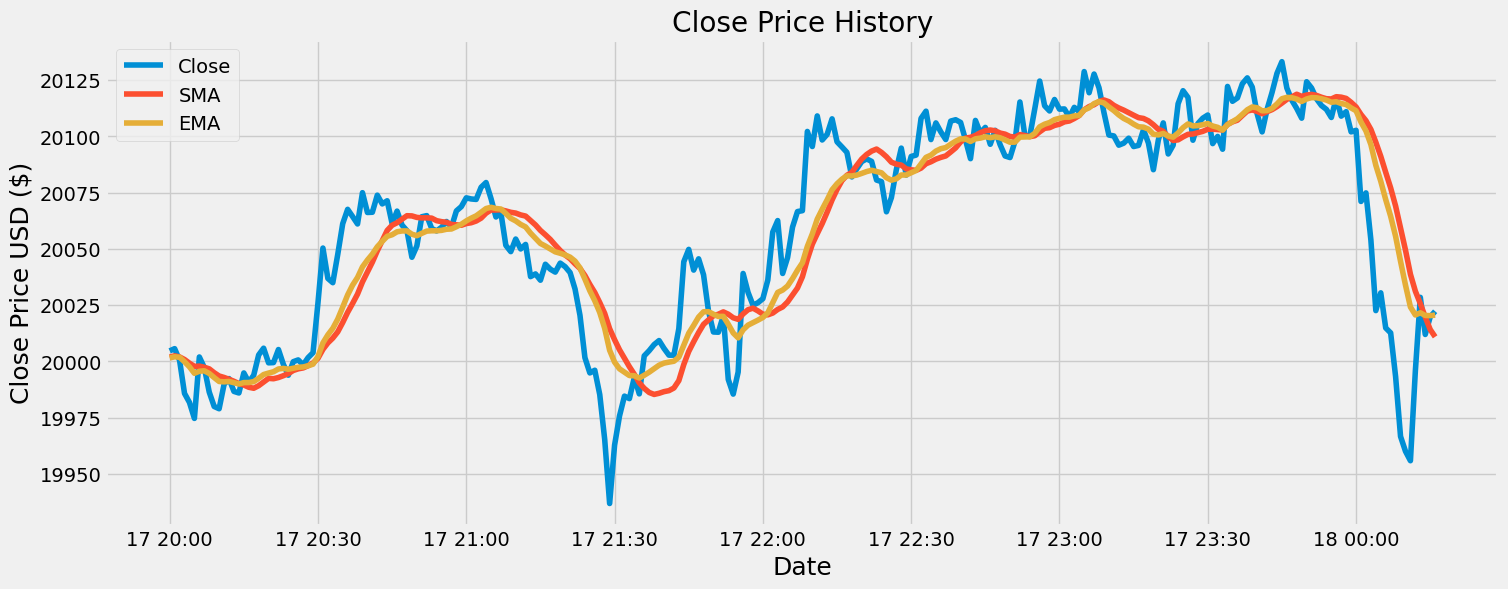

In [9]:
# Plot close price history
start = np.datetime64('2022-09-17 20:00:00')
end = np.datetime64('2022-09-18 00:16:00')
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df[start : end]['Close'], label='Close')
plt.plot(df[start : end]['SMA of close price'], label='SMA')
plt.plot(df[start : end]['EMA of close price'], label='EMA')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.legend()
plt.show()


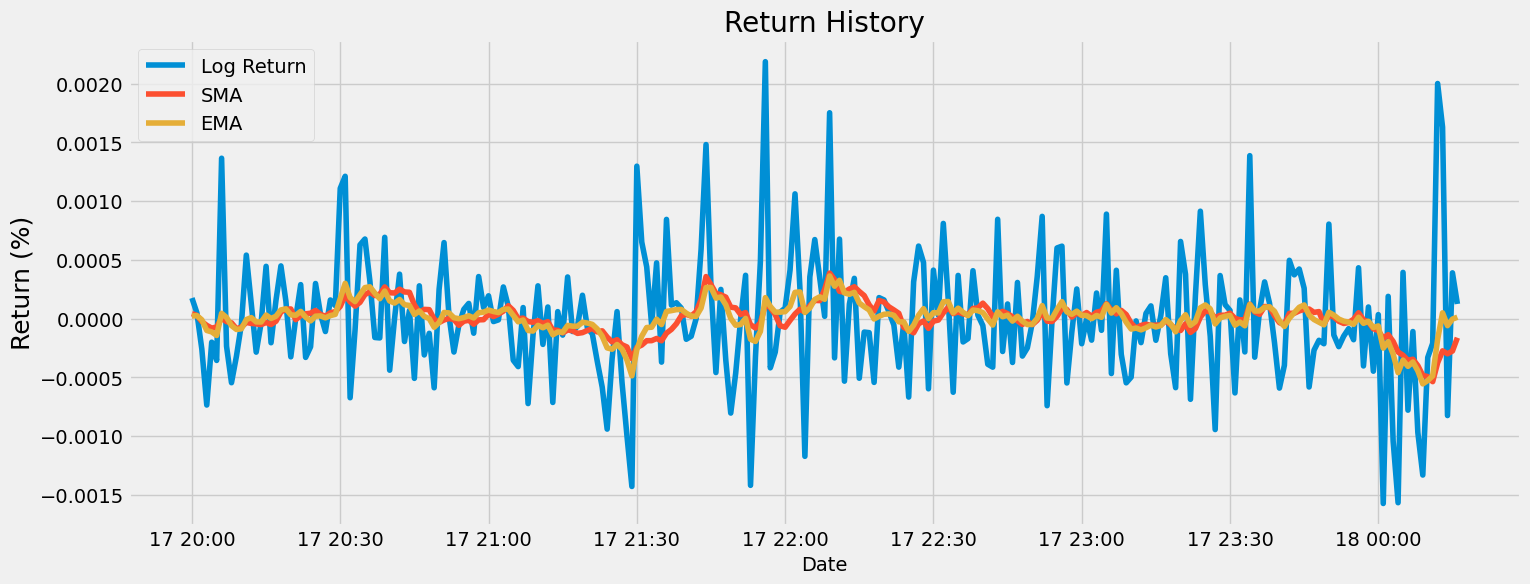

In [10]:
# Plot return history
plt.figure(figsize=(16, 6))
plt.title('Return History')
plt.plot(df[start : end]['Log Return'], label='Log Return')
plt.plot(df[start : end]['SMA of Log Return'], label='SMA')
plt.plot(df[start : end]['EMA of Log Return'], label='EMA')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Return (%)', fontsize=18)
plt.legend()
plt.show()

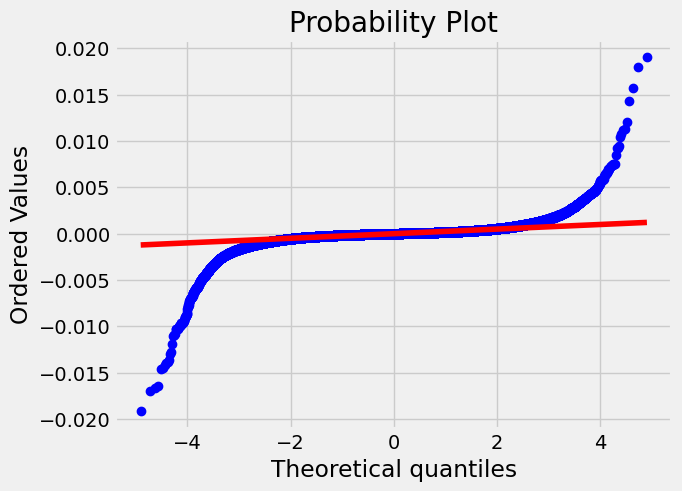

In [11]:
probplot(df['EMA of Log Return'],dist='norm',fit= True,plot=plt);

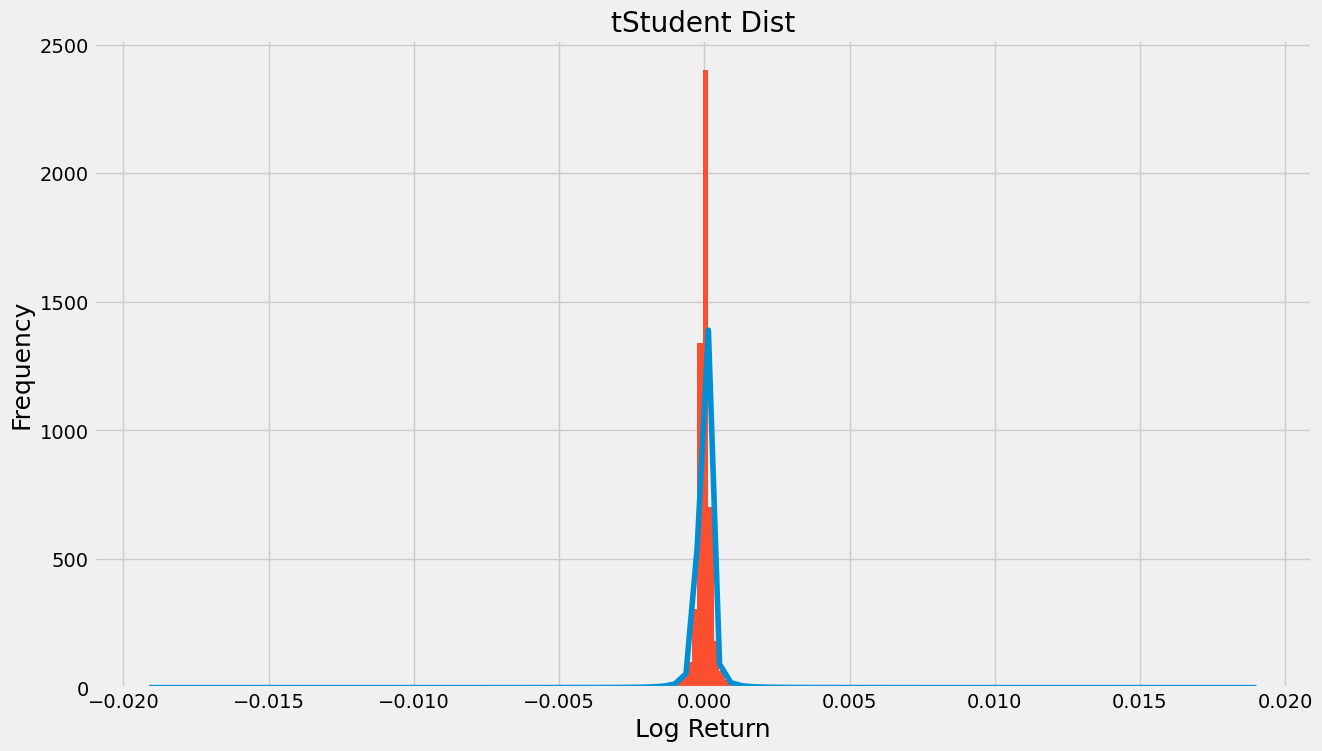

In [12]:
x_list = np.linspace(
                    df['EMA of Log Return'].min(),
                    df['EMA of Log Return'].max(),
                    100
                    )

params = t.fit(df['EMA of Log Return'].dropna())
degree_of_freedom, loc, scale = params

y_list = t.pdf(x_list, degree_of_freedom, loc, scale)

plt.figure(figsize=(14,8))
plt.title('tStudent Dist')
plt.xlabel('Log Return', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.plot(x_list,y_list);
plt.hist(df['EMA of Log Return'], bins=200,density=True);

### Processing data

In [13]:
# features list
features = ['EMA of Log Return']
feature_size = len(features)
feature_size

1

In [14]:
# Create a new dataframe with features
df = df.filter(features)
print(type(df))
df

<class 'pandas.core.frame.DataFrame'>


,EMA of Log Return
date,
2020-01-01 00:15:00,-0.000026
2020-01-01 00:16:00,-0.000076
2020-01-01 00:17:00,-0.000091
2020-01-01 00:18:00,-0.000104
2020-01-01 00:19:00,-0.000075
...,...
2022-10-31 00:14:00,0.000056
2022-10-31 00:15:00,0.000117
2022-10-31 00:16:00,0.000016


In [15]:
# Construct time series dataset for pytorch
result = df.reset_index()
result = result.rename(columns={"index":"time_idx"})
result['time_idx'] = result.index
result['group'] = 1
result

,date,EMA of Log Return,time_idx,group
0,2020-01-01 00:15:00,-0.000026,0,1
1,2020-01-01 00:16:00,-0.000076,1,1
2,2020-01-01 00:17:00,-0.000091,2,1
3,2020-01-01 00:18:00,-0.000104,3,1
4,2020-01-01 00:19:00,-0.000075,4,1
...,...,...,...,...
1484893,2022-10-31 00:14:00,0.000056,1484893,1
1484894,2022-10-31 00:15:00,0.000117,1484894,1
1484895,2022-10-31 00:16:00,0.000016,1484895,1
1484896,2022-10-31 00:17:00,0.000049,1484896,1


In [20]:
# create the dataset from the pandas dataframe

max_prediction_length = 15
max_encoder_length = 60
training_cutoff = result['time_idx'].max() - max_prediction_length

data = TimeSeriesDataSet(
    result,
    group_ids = ['group'],
    target = features[0],
    time_idx = 'time_idx',
    min_encoder_length = max_encoder_length // 2,
    max_encoder_length = max_encoder_length,
    min_prediction_length = 1,
    max_prediction_length = max_prediction_length,
    #time_varying_unknown_reals = features,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    target_normalizer= GroupNormalizer(method='robust'),
)
data.get_parameters()
data = data.transform_values('data', data)

In [21]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time for each series
validation = TimeSeriesDataSet.from_dataset(data, result, predict=True, stop_randomization=True)

In [22]:
# create dataloaders for model
batch_size = 1024
train_dataloader = data.to_dataloader(train=True, batch_size=batch_size, num_workers=4, pin_memory=True)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=2, pin_memory=True)

### Create baseline model
Evaluating a Baseline model that predicts the next 6 months by simply repeating the last observed volume gives us a simle benchmark that we want to outperform.

In [23]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

3.166660826536827e-05

### Building Model using Temporal Fusion Transformer (TFT)
It is now time to create our TemporalFusionTransformer model. We train the model with PyTorch Lightning.

#### Find optimal learning rate
Prior to training, you can identify the optimal learning rate with the PyTorch Lightning learning rate finder.

In [25]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
    auto_select_gpus=True,
    # clipping gradients is a hyperparameter and important to prevent divergence of the gradient for recurrent neural networks
    gradient_clip_val=0.02,
    #limit_train_batches=10,
    #limit_val_batches=10,

)


tft = TemporalFusionTransformer.from_dataset(
    data,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.002,
    hidden_size=100,  # most important hyperparameter apart from learning rate
    lstm_layers=2,
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=4,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=50,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
    loss = QuantileLoss(),
)
print(f'Number of parameters in network: {tft.size()/1e3:.1f}k')

Global seed set to 42
Auto select gpus: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 743.8k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Restoring states from the checkpoint path at C:\dev\python\Time series Prediction with pytorch\.lr_find_2db4cfd1-2a27-4432-aca1-80d1f1f564cb.ckpt


suggested learning rate: 0.09332543007969905


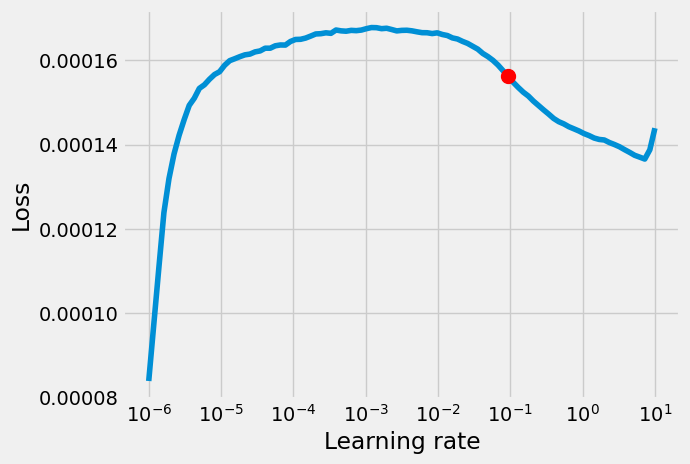

In [26]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,

)

print(f'suggested learning rate: {res.suggestion()}')
fig = res.plot(show=True, suggest=True)
fig.show()

### Train model

In [28]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=False, mode='min')
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger('lightning_logs')  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=10,
    accelerator='gpu',
    #devices=1,
    auto_select_gpus=True,
    enable_model_summary=True,
    gradient_clip_val=0.02,
    #limit_train_batches=30,  # comment in for training, running validation every 30 batches
    #fast_dev_run=True,  # comment in to check that network dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
    #auto_scale_batch_size=True
)


tft = TemporalFusionTransformer.from_dataset(
    data,
    learning_rate=0.05,
    hidden_size=100,
    lstm_layers=2,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=50,
    output_size=7,  # 7 quantiles by default
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
    loss = QuantileLoss(),
)
print(f'Number of parameters in network: {tft.size()/1e3:.1f}k')

Auto select gpus: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 743.8k


In [29]:
# fit network
# tensorboard --logdir=./ in terminal
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 400   
4  | static_variable_selection          | VariableSelectionNetwork        | 48.2 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 15.9 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 15.9 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 40.6 K
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 40.6 K
9  | static_context_initial_cell_lstm 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


### Hyperparameter tuning

### Evaluate performance

In [30]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [31]:
# calculate mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean().item()

9.626677638152614e-05

In [32]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode='raw', return_x=True)

IndexError: index 1 is out of bounds for dimension 0 with size 1

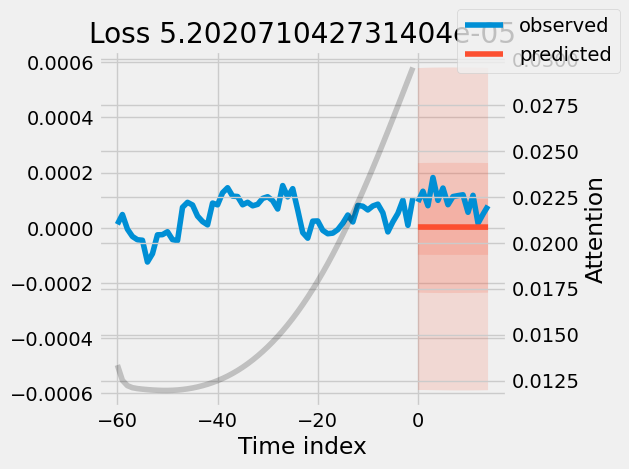

In [33]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

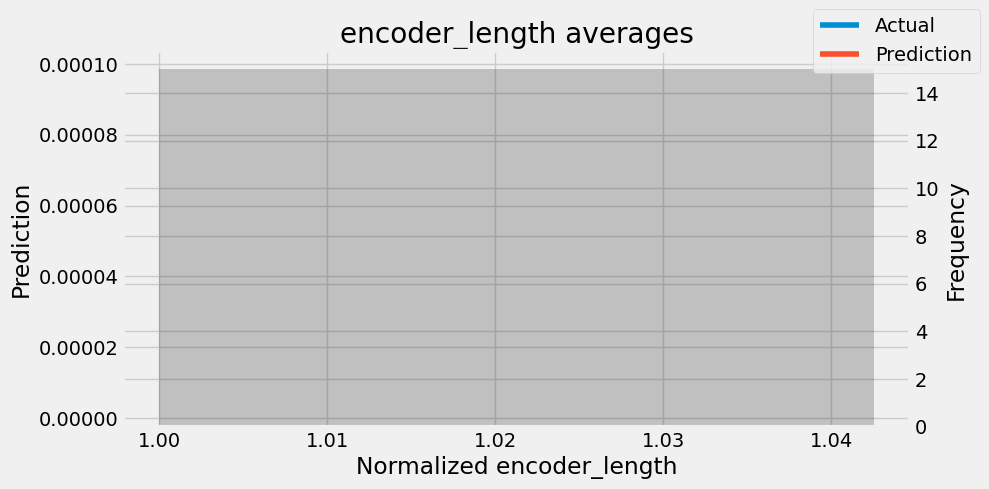

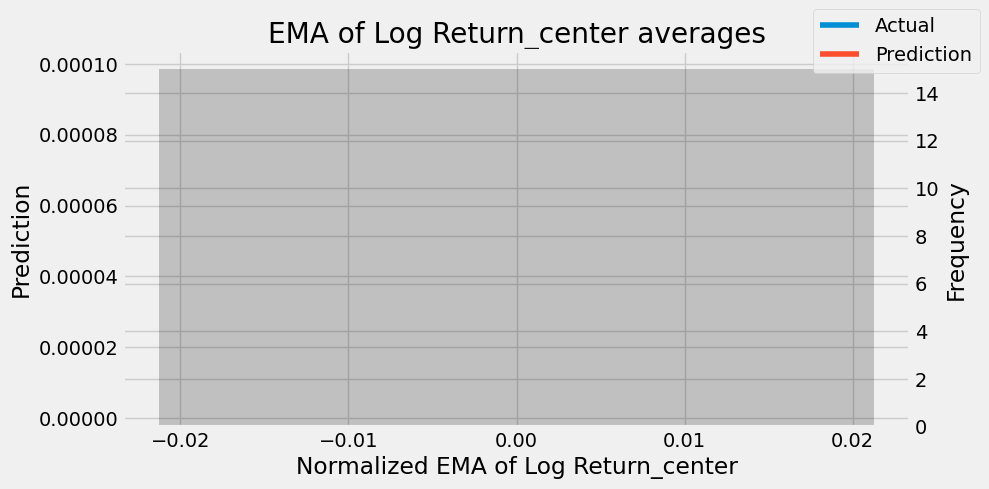

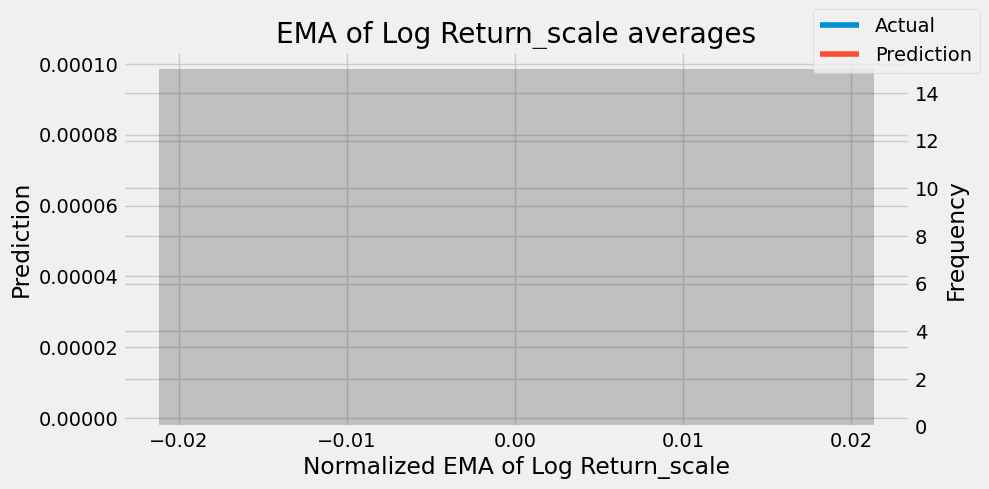

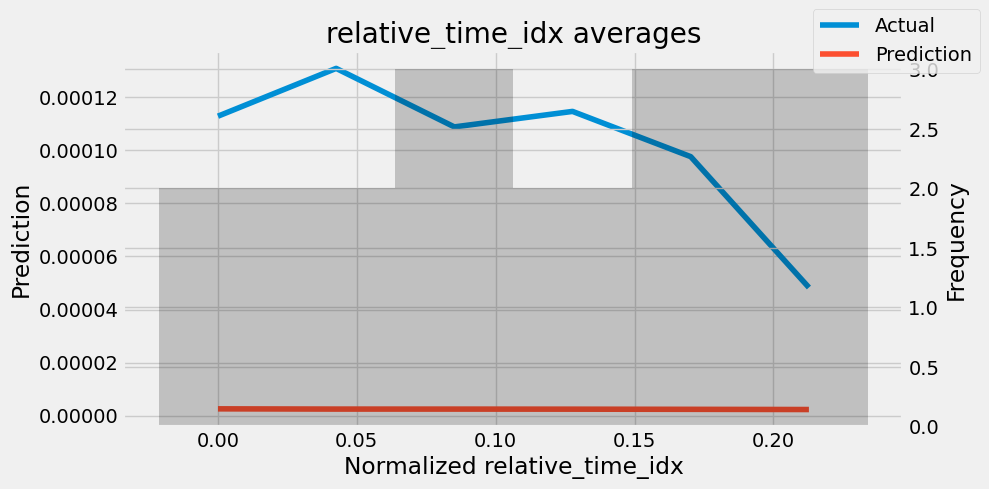

In [34]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);